# Regression Analysis of C-Peptide Dependence on Age and Base Deficit

## INTRO AND SUMMARY GOES HERE

### Question: 
When studying patterns of insulin-dependent diabetes mellitus in children, is there a relationship between levels of serum C-Peptide and the factors of patient age and base deficit?

### Data Source:
KEEL Diabetes Data Set
KEEL Diabetes Dataset (By KEEL). (n.d.). [Dataset]. https://sci2s.ugr.es/keel/dataset.php?cod=45

### Data Structure:

`Age`: Patient Age, domain: [0.9,15.6]

`Deficit`: Base Deficit, measure of acidity, domain: [-29.0,-0.2]

`C-peptide`: Logarithm of C-Peptide concentration (pmol/ml), domain: [3.0,6.6]

### Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os
import io
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

### Download Data into data/ directory
This code was adapted from Microsoft Copilot prompts:
'Use Python to download a data file from a download link into a directory, as a csv'

In [2]:
url = "https://sci2s.ugr.es/keel/dataset/data/regression/diabetes.zip"

file_path = os.path.join("data", "diabetes.zip")

response = requests.get(url)
zip_bytes = io.BytesIO(response.content)

with open(file_path, "wb") as f:
    f.write(response.content)


In [3]:
with zipfile.ZipFile(zip_bytes, "r") as zip_ref:
    dat_files = [f for f in zip_ref.namelist() if f.endswith(".dat")]
    dat_content = zip_ref.read(dat_files[0]).decode("utf-8")

### Data Wrangling and Cleaning
1. original file downloads as .dat, ensure it fits with a .csv format by splitting with the ',' delimiter and stripping lines beginning with '@'
2. re-name columns since names were stripped away
3. ensure data is the correct dtype

In [4]:
lines = dat_content.splitlines()
data_lines = [line for line in lines if not line.startswith("@") and line.strip()]

In [5]:
rows = [line.strip().split(",") for line in data_lines]
diabetes_df = pd.DataFrame(rows)

diabetes_df.columns = ["Age", "Deficit", "C_peptide"]
diabetes_df = diabetes_df.astype(float)

Note: dtypes were set to float manually as they were downloaded as dtype: object

In [6]:
csv_path = os.path.join("data", "diabetes.csv")
diabetes_df.to_csv(csv_path, index=False)

### Splitting the Data before EDA

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(diabetes_df, test_size = 0.3, random_state = 123)

### EDA

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 24 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        30 non-null     float64
 1   Deficit    30 non-null     float64
 2   C_peptide  30 non-null     float64
dtypes: float64(3)
memory usage: 960.0 bytes


No null values, data types were set to float earlier

In [9]:
train_df.describe()

,Age,Deficit,C_peptide
count,30.000000,30.000000,30.000000
mean,9.183333,-8.123333,4.720000
std,3.786007,7.354880,0.588042
min,1.800000,-29.000000,3.400000
25%,5.625000,-11.725000,4.500000
50%,10.550000,-6.950000,4.800000
75%,11.725000,-2.025000,5.100000
max,15.500000,-0.700000,6.000000


The mean patient age is 9 years old, with the maximum age being 15.5 and the minimum being 1.8. The C_peptide concentratio average is about 4.72, mean Base Deficit value is -8.12 mEq/L. The standard deviation of Base Deficit is quite high, at about 7.4 mEq/L, while the stdevs of the other two variables are within a reasonable range for their domains. This high variance could be due to the small size of the dataset.

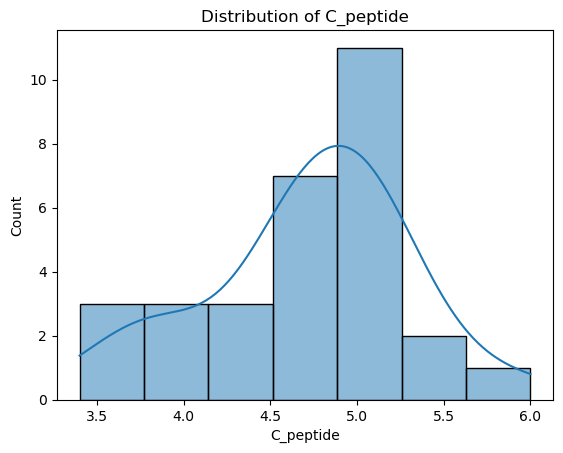

In [10]:
sns.histplot(train_df["C_peptide"], kde=True)
plt.title("Distribution of C_peptide")
plt.show()

In [11]:
alt.Chart(train_df).mark_circle().encode(
    x=alt.X(alt.repeat("column"), type="quantitative"),
    y=alt.Y(alt.repeat("row"), type="quantitative")
).properties(
    width=150,
    height=150
).repeat(
    row=["Age", "Deficit", "C_peptide"],
    column=["Age", "Deficit", "C_peptide"]
)


alt.RepeatChart(...)

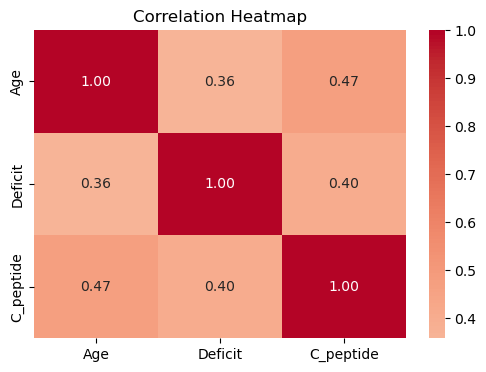

In [12]:
corr = train_df.corr()


plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center = 0, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### EDA Summary:
Both features are positively associated with the target variable, `C_peptide`, at approximately equal magnitudes (0.40 and 0.47). The distribution of the target variable is approximately normal, with most values clustered around 4.5 - 5.0. There does seem to be one or two outliers in scatterplots comparing the relationship between `Age` and `Deficit`, but as these are both non-target features this can be ignored for the sake of this analysis. There are no obvious outliers in the relationship between the target and its predictors.

### Modelling

We use linear regression to model the relationship between `C_peptide` and covariates `Age` and `Deficit`.

In [13]:
X = train_df.drop(columns=["C_peptide"])
y = train_df["C_peptide"]

In [14]:
import pingouin as pg

model = pg.linear_regression(X, y)
model

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.353915,0.321709,13.533717,1.509587e-13,0.285889,0.232992,3.693823,5.014007
1,Age,0.058702,0.027054,2.169793,3.899157e-02,0.285889,0.232992,0.003191,0.114212
2,Deficit,0.021296,0.013926,1.529171,1.378546e-01,0.285889,0.232992,-0.007279,0.049870


### Model Diagnostics

In [15]:
resid = model.residuals_

To check for Normality of residuals, we employ the Shapiro-Wilk test and Q-Q plot.

In [16]:
pg.normality(resid, method = "shapiro")

,W,pval,normal
0,0.982188,0.880261,True


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

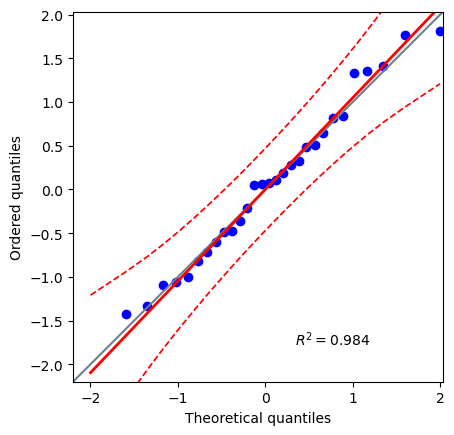

In [17]:
pg.qqplot(resid)

To test for equal variance, we plot the residuals against the fitted values for the model.

In [18]:
fitted_df = pd.DataFrame({
    "observed": y,
    "fitted": y - resid,
    "residuals": resid
})

alt.Chart(fitted_df).mark_point().encode(
    x=alt.X(
        "fitted",
        scale=alt.Scale(zero=False)
    ).title("Fitted Values"),
    y=alt.Y(
        "residuals",
        scale=alt.Scale(zero=False)
    ).title("Residuals")
)

alt.Chart(...)

## DISCUSSION HERE

Some things that could be included:
- interpret coefficients and their p-values
- model assumptions and whether they were violated